Epoch[1/65], G Loss: 1.2420, D Loss: 7.6350


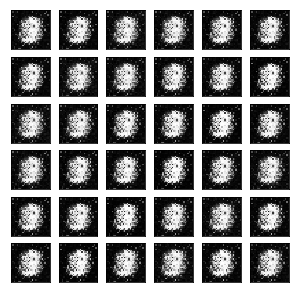

Epoch[2/65], G Loss: 0.7950, D Loss: 7.6689


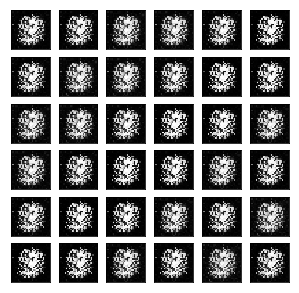

Epoch[3/65], G Loss: 0.6609, D Loss: 7.8946


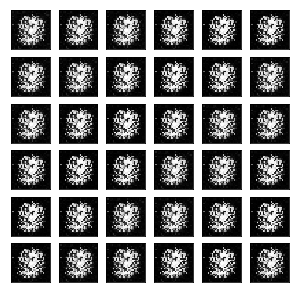

Epoch[4/65], G Loss: 0.6944, D Loss: 8.8249


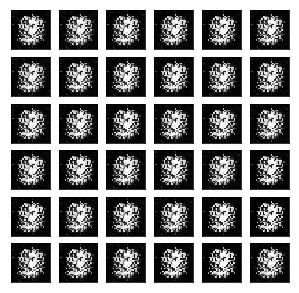

Epoch[5/65], G Loss: 0.7250, D Loss: 9.0175


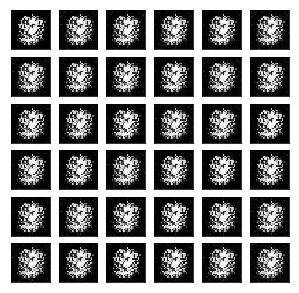

Epoch[6/65], G Loss: 0.7466, D Loss: 9.0695


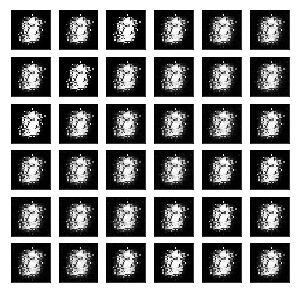

Epoch[7/65], G Loss: 0.7706, D Loss: 9.0929


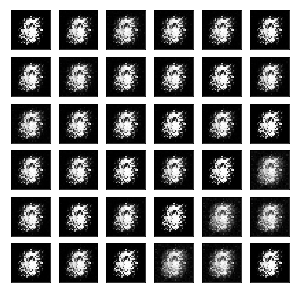

Epoch[8/65], G Loss: 0.7981, D Loss: 8.9634


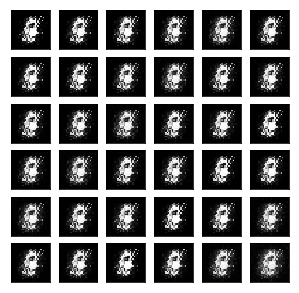

Epoch[9/65], G Loss: 0.8001, D Loss: 9.0122


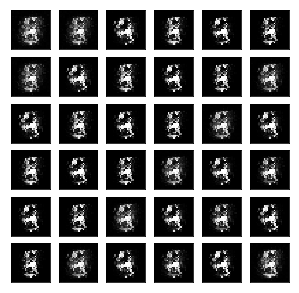

Epoch[10/65], G Loss: 0.7495, D Loss: 9.1447


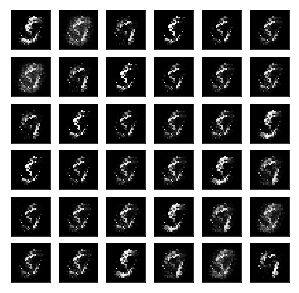

Epoch[11/65], G Loss: 0.7414, D Loss: 8.9080


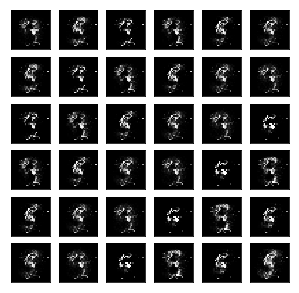

Epoch[12/65], G Loss: 0.7509, D Loss: 8.7446


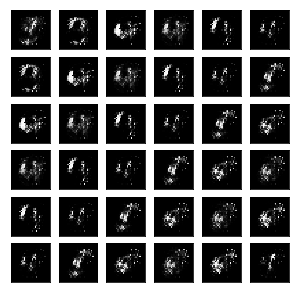

Epoch[13/65], G Loss: 0.6932, D Loss: 8.8427


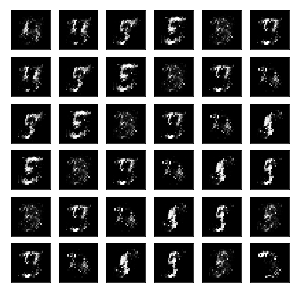

Epoch[14/65], G Loss: 0.6986, D Loss: 8.7912


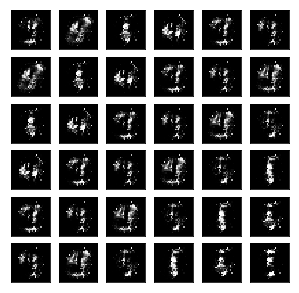

Epoch[15/65], G Loss: 0.6943, D Loss: 8.8343


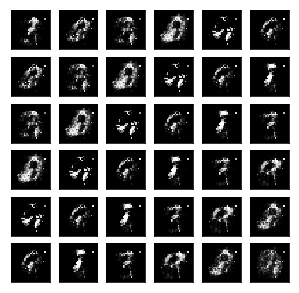

Epoch[16/65], G Loss: 0.7044, D Loss: 8.6909


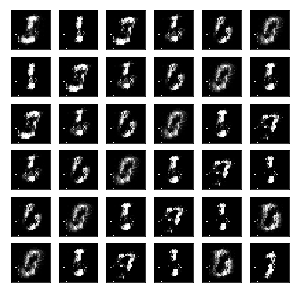

Epoch[17/65], G Loss: 0.7163, D Loss: 8.6708


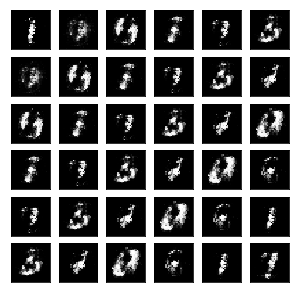

Epoch[18/65], G Loss: 0.7219, D Loss: 8.2872


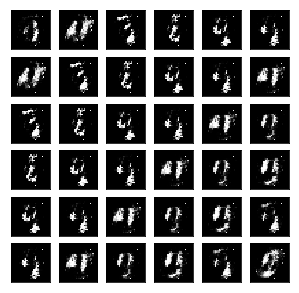

Epoch[19/65], G Loss: 0.7411, D Loss: 7.4817


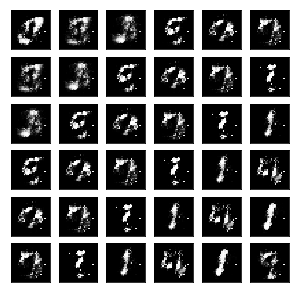

Epoch[20/65], G Loss: 0.7427, D Loss: 7.2678


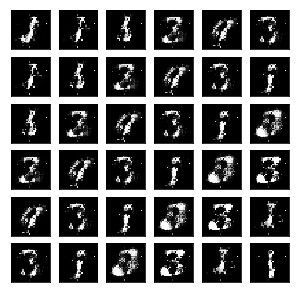

Epoch[21/65], G Loss: 0.7931, D Loss: 7.4942


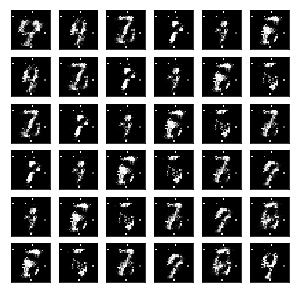

Epoch[22/65], G Loss: 0.8366, D Loss: 6.7905


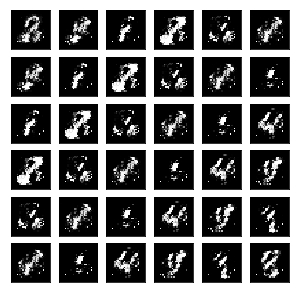

Epoch[23/65], G Loss: 0.8776, D Loss: 5.3459


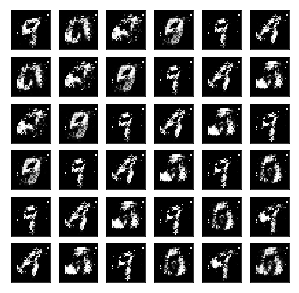

Epoch[24/65], G Loss: 0.9365, D Loss: 4.6926


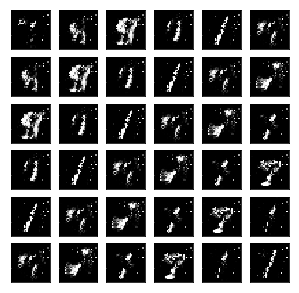

Epoch[25/65], G Loss: 1.1170, D Loss: 4.4631


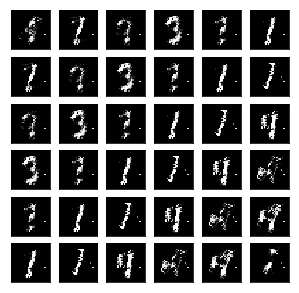

Epoch[26/65], G Loss: 1.2040, D Loss: 2.9425


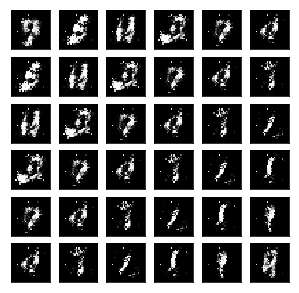

Epoch[27/65], G Loss: 1.3118, D Loss: 2.2939


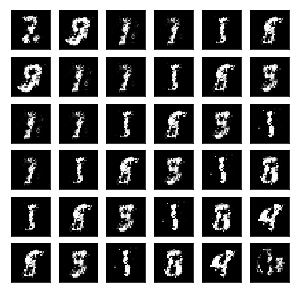

Epoch[28/65], G Loss: 1.4323, D Loss: 2.0674


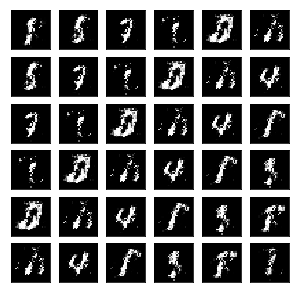

Epoch[29/65], G Loss: 1.4732, D Loss: 1.7523


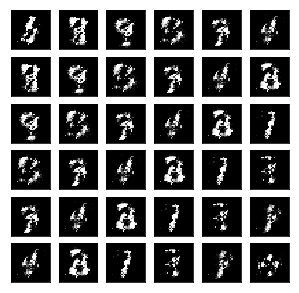

Epoch[30/65], G Loss: 1.5283, D Loss: 1.5802


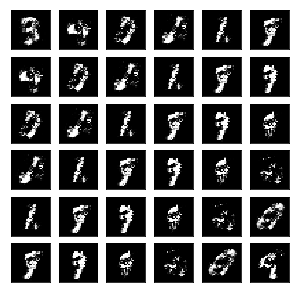

Epoch[31/65], G Loss: 1.6116, D Loss: 1.5367


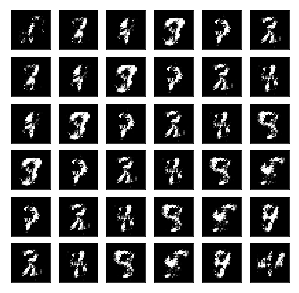

Epoch[32/65], G Loss: 1.6977, D Loss: 1.5001


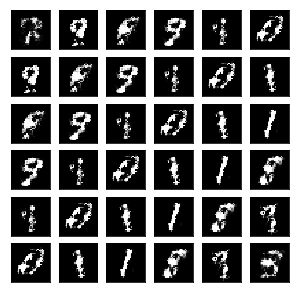

Epoch[33/65], G Loss: 1.7096, D Loss: 1.4447


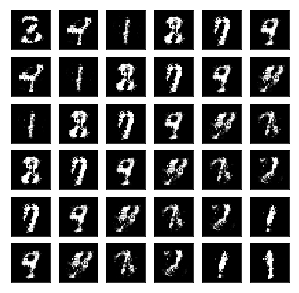

Epoch[34/65], G Loss: 1.7292, D Loss: 1.2935


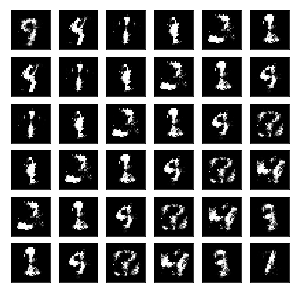

Epoch[35/65], G Loss: 1.8061, D Loss: 1.2000


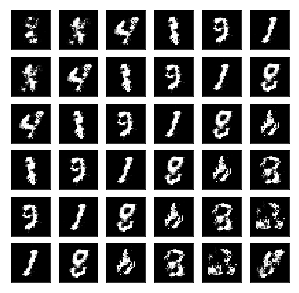

Epoch[36/65], G Loss: 1.8366, D Loss: 1.1378


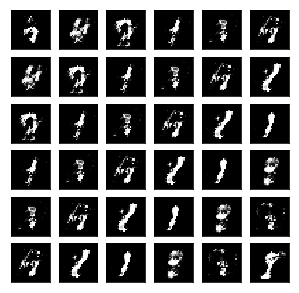

Epoch[37/65], G Loss: 1.8634, D Loss: 1.1328


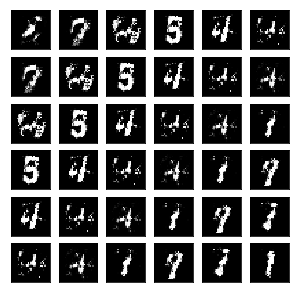

Epoch[38/65], G Loss: 1.8972, D Loss: 1.0955


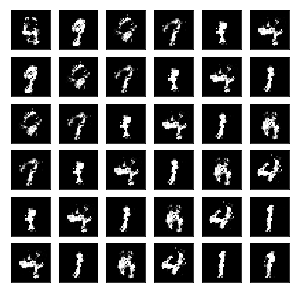

Epoch[39/65], G Loss: 1.9106, D Loss: 1.0490


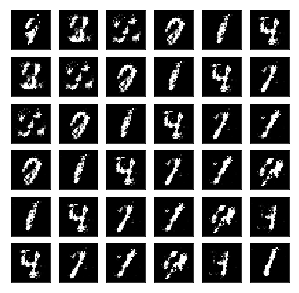

Epoch[40/65], G Loss: 1.8534, D Loss: 1.0912


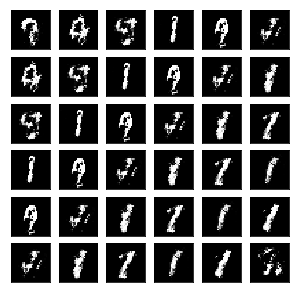

Epoch[41/65], G Loss: 1.7981, D Loss: 1.0454


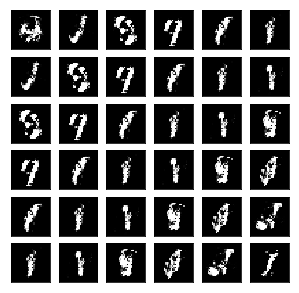

Epoch[42/65], G Loss: 1.8841, D Loss: 1.0175


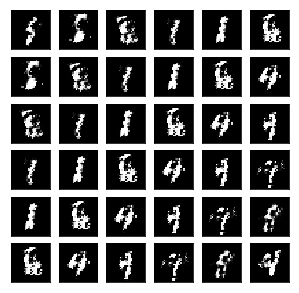

Epoch[43/65], G Loss: 1.8382, D Loss: 0.9990


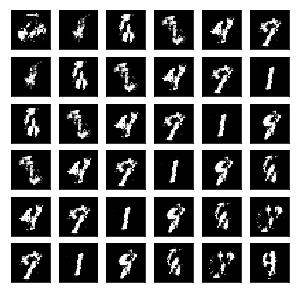

KeyboardInterrupt: 

In [1]:
""" (DRAGAN)
Deep Regret Analytic GAN

https://arxiv.org/pdf/1705.07215.pdf

The output of DRAGAN's D can be interpretted as a probability, similarly to MMGAN
and NSGAN.

Proposes to study GANs from a regret minimization perspective. This implementation is 
very similar to WGAN GP, in that it is applying a gradient penalty to try and get at 
an improved training objective based on how D and G would optimally perform. They apply 
the gradient penalty only close to the real data manifold (whereas WGAN GP picks the 
gradient location on a random line between a real and randomly generated fake sample). 
For further details, see Section 2.5 of the paper.

DRAGAN is very similar to WGANGP, but seems much less stable. I would spend more time on
WGANGP than DRAGAN.
"""

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import os
import matplotlib.pyplot as plt
import numpy as np

from itertools import product
from tqdm import tqdm_notebook
from load_data import get_data


def to_var(x):
    """ Make a tensor cuda-erized and requires gradient """
    return to_cuda(x).requires_grad_()

def to_cuda(x):
    """ Cuda-erize a tensor """
    if torch.cuda.is_available():
        x = x.cuda()
    return x

# Enable Jupyter notebook plotting
%matplotlib inline

# Load in binarized MNIST data, separate into data loaders
train_iter, val_iter, test_iter = get_data()


class Generator(nn.Module):
    """ Generator. Input is noise, output is a generated image. 
    """
    def __init__(self, image_size, hidden_dim, z_dim):
        super().__init__()
        
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.generate = nn.Linear(hidden_dim, image_size)
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        generation = torch.sigmoid(self.generate(activated))
        return generation


class Discriminator(nn.Module):
    """ Critic (not trained to classify). Input is an image (real or generated), 
    output is the approximate Wasserstein Distance between z~P(G(z)) and real.
    """
    def __init__(self, image_size, hidden_dim, output_dim):
        super().__init__()
        
        self.linear = nn.Linear(image_size, hidden_dim)
        self.discriminate = nn.Linear(hidden_dim, output_dim)     
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        discrimination = torch.sigmoid(self.discriminate(activated))
        return discrimination


class DRAGAN(nn.Module):
    """ Super class to contain both Discriminator (D) and Generator (G) 
    """
    def __init__(self, image_size, hidden_dim, z_dim, output_dim=1):
        super().__init__()
        
        self.G = Generator(image_size, hidden_dim, z_dim)
        self.D = Discriminator(image_size, hidden_dim, output_dim)
        
        self.z_dim = z_dim


class DRAGANTrainer:
    """ Object to hold data iterators, train a GAN variant 
    """
    def __init__(self, model, train_iter, val_iter, test_iter, viz=False):
        self.model = to_cuda(model)
        self.name = model.__class__.__name__
        
        self.train_iter = train_iter
        self.val_iter = val_iter
        self.test_iter = test_iter
        
        self.Glosses = []
        self.Dlosses = []
        
        self.viz = viz

    def train(self, num_epochs, G_lr=1e-4, D_lr=1e-4, D_steps=5):
        """ Train a Deep Regret Analytic GAN
            Logs progress using G loss, D loss, G(x), D(G(x)), visualizations of Generator output.

        Inputs:
            num_epochs: int, number of epochs to train for
            G_lr: float, learning rate for generator's Adam optimizer (default 1e-4)
            D_lr: float, learning rate for discriminator's Adam optimizer (default 1e-4)
            D_steps: int, training step ratio for how often to train D compared to G (default 5)
        """
        # Initialize optimizers
        G_optimizer = torch.optim.Adam(params=[p for p in self.model.G.parameters() if p.requires_grad], lr=G_lr)
        D_optimizer = torch.optim.Adam(params=[p for p in self.model.D.parameters() if p.requires_grad], lr=D_lr)
    
        # Approximate steps/epoch given D_steps per epoch --> roughly train in the same way as if D_step (1) == G_step (1)
        epoch_steps = int(np.ceil(len(train_iter) / (D_steps))) 
        
        # Begin training
        for epoch in tqdm_notebook(range(1, num_epochs+1)):
            self.model.train()
            G_losses, D_losses = [], []
            
            for _ in range(epoch_steps):
                
                D_step_loss = []
                
                for _ in range(D_steps): 

                    # Reshape images
                    images = self.process_batch(self.train_iter)

                    # TRAINING D: Zero out gradients for D
                    D_optimizer.zero_grad()

                    # Train the discriminator to approximate the Wasserstein distance between real, generated
                    # distributions                    
                    D_loss = self.train_D(images)
                    
                    # Update parameters
                    D_loss.backward()
                    D_optimizer.step()
                    
                    # Log results, backpropagate the discriminator network
                    D_step_loss.append(D_loss.item())
                                                        
                # We report D_loss in this way so that G_loss and D_loss have the same number of entries.
                D_losses.append(np.mean(D_step_loss))
                
                # TRAINING G: Zero out gradients for G
                G_optimizer.zero_grad()

                # Train the generator to (roughly) minimize the approximated Wasserstein distance
                G_loss = self.train_G(images)
                
                # Log results, update parameters
                G_losses.append(G_loss.item())
                G_loss.backward()
                G_optimizer.step()
            
            # Save progress
            self.Glosses.extend(G_losses)
            self.Dlosses.extend(D_losses)
                            
            # Progress logging
            print ("Epoch[%d/%d], G Loss: %.4f, D Loss: %.4f"
                   %(epoch, num_epochs, np.mean(G_losses), np.mean(D_losses)))
            self.num_epochs = epoch
            
            # Visualize generator progress
            self.generate_images(epoch)
            
            if self.viz:
                plt.show()       
        
    def train_D(self, images, LAMBDA=10, K=1, C=1):
        """ Run 1 step of training for discriminator

        Input:
            model: model instantiation
            images: batch of images (reshaped to [batch_size, 784])
        Output:
            D_loss: DRAGAN loss for discriminator, 
            -E[log(D(x))] - E[log(1 - D(G(z)))] + λE[(||∇ D(G(z))|| - 1)^2]
        """     
        
        # Classify the real batch images, get the loss for these
        DX_score = self.model.D(images)

        # Sample noise z, generate output G(z)
        noise = self.compute_noise(images.shape[0], self.model.z_dim)
        G_output = self.model.G(noise)

        # Classify the fake batch images, get the loss for these using sigmoid cross entropy
        DG_score = self.model.D(G_output)

        # Compute vanilla (original paper) D loss
        D_loss = -torch.mean(torch.log(DX_score + 1e-8) + torch.log(1 - DG_score + 1e-8))

        # GRADIENT PENALTY STEPS:
        # Uniformly sample along one straight line per each batch entry. 
        delta = to_cuda(torch.rand(images.shape[0], 1).expand(images.size()))

        # Generate images from the noise, ensure unit 
        G_interpolation = to_var(delta*images.data + (1-delta) * 
                                 (images.data + C*images.data.std() * torch.rand(images.size())))

        # Discriminate generator interpolation
        D_interpolation = self.model.D(G_interpolation)

        # Compute the gradients of D with respect to the noise generated input
        gradients = torch.autograd.grad(outputs = D_interpolation, 
                                        inputs = G_interpolation,
                                        grad_outputs = to_cuda(torch.ones(D_interpolation.size())),
                                        only_inputs = True,
                                        create_graph = True,
                                        retain_graph = True)[0]

        # Full gradient penalty
        grad_penalty = LAMBDA * torch.mean((gradients.norm(2, dim=1) - K)**2)
        
        # Compute DRAGAN loss for D
        D_loss = D_loss + grad_penalty
        
        return D_loss
    
    def train_G(self, images):
        """ Run 1 step of training for generator
        
        Input:
            images: batch of images (reshaped to [batch_size, -1]) 
        Output:
            G_loss: DRAGAN (non-saturating) loss for G, -E[log(D(G(z)))]
        """   
        # Get noise (denoted z), classify it using G, then classify the output of G using D.
        noise = self.compute_noise(images.shape[0], self.model.z_dim) # (z)
        G_output = self.model.G(noise) # G(z)
        DG_score = self.model.D(G_output) # D(G(z))

        # Compute the non-saturating loss for how D did versus the generations of G using sigmoid cross entropy
        G_loss = -torch.mean(torch.log(DG_score + 1e-8))
        
        return G_loss
    
    def compute_noise(self, batch_size, z_dim):
        """ Compute random noise for the generator to learn to make images from """
        return to_cuda(torch.randn(batch_size, z_dim))
    
    def process_batch(self, iterator):
        """ Generate a process batch to be input into the discriminator D """
        images, _ = next(iter(iterator))
        images = to_cuda(images.view(images.shape[0], -1))
        return images
    
    def generate_images(self, epoch, num_outputs=36, save=True):
        """ Visualize progress of generator learning """
        # Turn off any regularization
        self.model.eval()
        
        # Sample noise vector
        noise = self.compute_noise(num_outputs, self.model.z_dim)
        
        # Transform noise to image
        images = self.model.G(noise)
        
        # Reshape to proper image size
        images = images.view(images.shape[0], 28, 28)
        
        # Plot
        plt.close()
        size_figure_grid = int(num_outputs**0.5)
        fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
        for i, j in product(range(size_figure_grid), range(size_figure_grid)):
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].cla()
            ax[i,j].imshow(images[i+j].data.numpy(), cmap='gray') 
        
        # Save images if desired
        if save:
            outname = '../viz/' + self.name + '/'
            if not os.path.exists(outname):
                os.makedirs(outname)
            torchvision.utils.save_image(images.unsqueeze(1).data, 
                                         outname + 'reconst_%d.png'
                                         %(epoch), nrow = 5)
    
    def viz_loss(self):
        """ Visualize loss for the generator, discriminator """
        # Set style, figure size
        plt.style.use('ggplot')
        plt.rcParams["figure.figsize"] = (8,6)

        # Plot Discriminator loss in red, Generator loss in green
        plt.plot(np.linspace(1, self.num_epochs, len(self.Dlosses)), self.Dlosses, 'r')
        plt.plot(np.linspace(1, self.num_epochs, len(self.Dlosses)), self.Glosses, 'g')
        
        # Add legend, title
        plt.legend(['Discriminator', 'Generator'])
        plt.title(self.name)
        plt.show()

    def save_model(self, savepath):
        """ Save model state dictionary """
        torch.save(self.model.state_dict(), savepath)
    
    def load_model(self, loadpath):
        """ Load state dictionary into model """
        state = torch.load(loadpath)
        self.model.load_state_dict(state)


model = DRAGAN(image_size=784, 
               hidden_dim=256, 
               z_dim=128)

trainer = DRAGANTrainer(model=model, 
                        train_iter=train_iter, 
                        val_iter=val_iter, 
                        test_iter=test_iter,
                        viz=True)

trainer.train(num_epochs=65,
              G_lr=1e-4,
              D_lr=1e-4,
              D_steps=1)